### Atividade da Aula

- **Aluno:** Augusto Mathias Adams

#### Parte 1

**Rode todo o código. Certifique-se de que você o compreendeu.**

Feito.

#### Parte 2
1. **Refaça todas as an ́alises presentes no código usando a taxa de acerto ao invés da taxa de erro.**

Feito em paralelo com o código original. Somente exigiu a mudança da função *calcula_erro_classificacao* para permitir o acúmulo de acertos ao invés de erros. A função *calcula_acerto_classificacao* foi criada com o código modificado.



# Avaliando a qualidade de uma rede neural (problema de classificação)


In [157]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')

tf.autograph.set_verbosity(0)

### Conjunto de dados

Rode a célula abaixo para gerar o conjunto de dados e para dividí-lo em dados de treinamento, validação-cruzada (CV) e dados de teste. Neste exemplo, usaremos propositalmente uma porcentagem maior para dados de validação cruzada para dar ênfase aos resultados encontrados

In [158]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Gerando dados
classes = 6     # qtdade de classes
m       = 800   # qtdade de amostras
desvio  = 0.4   # desvio em relação aos centros
centros = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
X, y    = make_blobs(n_samples=m, centers=centros, cluster_std=desvio, random_state=2, n_features=2)


# Dividindo os dados.
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


Abaixo nós importamos algumas funções auxiliares que serão usadas neste código

In [159]:
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.widgets import Button, CheckButtons
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

# from ipywidgets import Output
np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')


# Plota fronteira de decisão para múltiplas classes
# Essa versão lida com uma previsão não-vetorizada (adiciona um loop for sobre os pontos)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # Cria grade de pontos
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]

    #faz previsão para cada ponto
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    # Plot de contorno destaca as fronteiras entre os valores - classes nesse caso
    ax.contour(xx, yy, Z, colors=color, linewidths=lw)
    ax.axis('tight')

def recat(pt, origins):
    """ Classifica um ponto com base na distância dos clusters de origem """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(16,8))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Dados treinamento, Dados CV")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    # construindo modelo para rotinas de plot
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("performance ideal", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()


def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    # Plota a fronteira de decisão
    fig,ax = plt.subplots(1,2, figsize=(16,8))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("dados treinamento", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("dados validação cruzada", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes,
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


# Não usada mas calcula o erro sumando equidistância
def err_all_equal(X_train,X_cv,X_test, y_train,y_cv,y_test, centers):
    X_all = np.concatenate((X_train,X_cv,X_test), axis=0)
    y_all = np.concatenate((y_train,y_cv,y_test), axis=0)
    m = len(X_all)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X_all[i], centers)
    err_all = eval_cat_err(y_all, y_eq) # só pra lembrar que a função eval_cat_err não existe, certo? me passa o código original
    return(err_all)

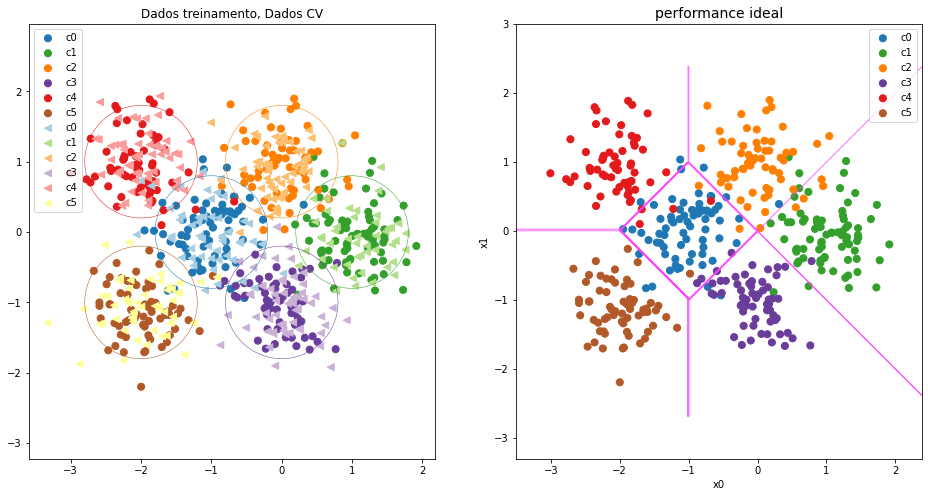

In [160]:
plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centros, desvio)

Acima, no gráfico da esquerda, você consegue ver os dados. Há 6 diferentes agrupamentos de amostras (clusters), identificados pelas diferentes cores. Tanto os dados de treinamento (pontos) como os dados de validação cruzada (triângulos) estão presentes. Os pontos interessantes são aqueles que estão localizados em regiões ambíguas. Como você acha que uma rede neural classificará tais amostras? Você espera que ocorra overfitting ou underfitting?

No gráfico da direita temos um exemplo do que pode ser considerado como sendo um modelo 'ideal' de referência. As linhas representam fronteiras de 'distâncias iguais' onde a distância entre os centros é igual. Esse modelo classifica de forma equivocada apenas 8% dos dados.


### Avaliando a qualidade de um modelo de classificação usando a taxa de erro

Para modelos que realizam classificação, podemos usar como métrica para availação da qualidade desse modelo a fração de amostras com previsão incorreta:

$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1}
\begin{cases}
    1, & \text{se $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{caso contrário}
\end{cases}
$$

Abaixo, tem-se uma função que automatiza o cálculo da taxa de erro. Note que, neste nosso código, os valores alvo são o índice da categoria (não trata-se de uma codificação do tipo [one-hot bit](https://en.wikipedia.org/wiki/One-hot)).

In [161]:
def calcula_erro_classificacao(y, y_chapeu):
    """
    Calcula o erro de categorização
    Argumentos:
      y    : (ndarray  Shape (m,) ou (m,1))  categorias alvo
      y_chapeu : (ndarray  Shape (m,) ou (m,1))  categorias previstas
    Retorna:
      classe_erro: (escalar)
    """
    m         = len(y)
    incorreto = 0
    for i in range(m):
        if(y_chapeu[i]!=y[i]):
            incorreto+=1
    classe_erro=incorreto/m
    return(classe_erro)

# função criada devido à atividade
def calcula_acerto_classificacao(y, y_chapeu):
    """
    Calcula o acerto de categorização
    Argumentos:
      y    : (ndarray  Shape (m,) ou (m,1))  categorias alvo
      y_chapeu : (ndarray  Shape (m,) ou (m,1))  categorias previstas
    Retorna:
      classe_acerto: (escalar)
    """
    m         = len(y)
    correto = 0
    for i in range(m):
        if(y_chapeu[i]==y[i]):
            correto+=1
    classe_acerto=correto/m
    return classe_acerto



In [162]:
# Abaixo testamos a implementação da nossa função:

y_chapeu = np.array([1, 2, 0])
y_tmp    = np.array([1, 2, 3])
print(f"erro de classificação encontrado: {np.squeeze(calcula_erro_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.333" )
# adicionado devido à atividade
print(f"Acerto de classificação encontrado: {np.squeeze(calcula_acerto_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.667" )
y_chapeu = np.array([[1], [2], [0], [3]])
y_tmp    = np.array([[1], [2], [1], [3]])
print(f"erro de classificação encontrado: {np.squeeze(calcula_erro_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.250" )
# adicionado devido à atividade
print(f"Acerto de classificação encontrado: {np.squeeze(calcula_acerto_classificacao(y_chapeu, y_tmp)):0.3f}, resultado esperado: 0.750" )


erro de classificação encontrado: 0.333, resultado esperado: 0.333
Acerto de classificação encontrado: 0.667, resultado esperado: 0.667
erro de classificação encontrado: 0.250, resultado esperado: 0.250
Acerto de classificação encontrado: 0.750, resultado esperado: 0.750


Na célula acima, teste diferentes exemplos para verificar seu entendimento acerca da taxa de erro de classificação

## Modelo complexo

Abaixo criamos uma rede neural complexa para tentar resolver tal problema de classificação.

In [163]:
tf.random.set_seed(1234) # define uma semente fixa para o gerador de números aleatórios do tensorflow
modelo = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="softmax")
    ], name="Modelo_complexo"
)
modelo.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

In [164]:
modelo.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9773
Epoch 2/1000
13/13 [==============================] - 0s 964us/step - loss: 0.3902
Epoch 3/1000
13/13 [==============================] - 0s 889us/step - loss: 0.3194
Epoch 4/1000
13/13 [==============================] - 0s 862us/step - loss: 0.2741
Epoch 5/1000
13/13 [==============================] - 0s 821us/step - loss: 0.2507
Epoch 6/1000
13/13 [==============================] - 0s 992us/step - loss: 0.2786
Epoch 7/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2427
Epoch 8/1000
13/13 [==============================] - 0s 958us/step - loss: 0.2271
Epoch 9/1000
13/13 [==============================] - 0s 812us/step - loss: 0.2311
Epoch 10/1000
13/13 [==============================] - 0s 868us/step - loss: 0.1976
Epoch 11/1000
13/13 [==============================] - 0s 887us/step - loss: 0.2164
Epoch 12/1000
13/13 [==============================] - 0s 994us/step - loss: 0.2043
Ep

In [165]:
modelo.summary()

Model: "Modelo_complexo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 120)               360       
                                                                 
 dense_193 (Dense)           (None, 40)                4840      
                                                                 
 dense_194 (Dense)           (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1082/1082 [==============================] - 1s 542us/step


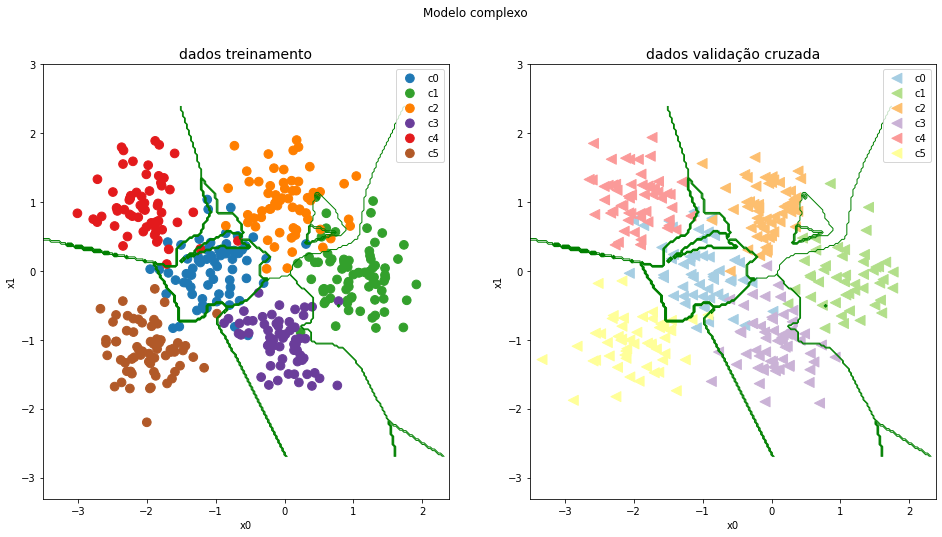

In [166]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao = lambda Xl: np.argmax(tf.nn.softmax(modelo.predict(Xl)).numpy(),axis=1)


plt_nn(modelo_previsao,X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo complexo")

Olhando no gráfico da esquerda, note que esse modelo complexo se esforçou para capturar amostras distoantes (outliers) de cada categoria. O problema é que tais amostras distoantes não representam o comportamento fundamental presente nesses dados. O resultado disso é um modelo que erra na classificação de diversas amostras presentes nos dados de validação cruzada (gráfico da direita).

Abaixo nós calculamos a taxa de erro de classificação.

In [167]:
training_cerr_complex = calcula_erro_classificacao(y_train, modelo_previsao(X_train))
cv_cerr_complex       = calcula_erro_classificacao(y_cv, modelo_previsao(X_cv))
training_cacc_complex = calcula_acerto_classificacao(y_train, modelo_previsao(X_train))
cv_cacc_complex       = calcula_acerto_classificacao(y_cv, modelo_previsao(X_cv))
print(f"taxa de erro, treinamento, modelo complexo: {100*training_cerr_complex:0.3f} %")
print(f"taxa de erro, cv,          modelo complexo: {100*cv_cerr_complex:0.3f} %")
# adicionado devido à atividade
print(f"taxa de acerto, treinamento, modelo complexo: {100*training_cacc_complex:0.3f} %")
print(f"taxa de acerto, cv,          modelo complexo: {100*cv_cacc_complex:0.3f} %")

10/10 [==============================] - 0s 653us/step
taxa de erro, treinamento, modelo complexo: 5.750 %
taxa de erro, cv,          modelo complexo: 10.000 %
taxa de acerto, treinamento, modelo complexo: 94.250 %
taxa de acerto, cv,          modelo complexo: 90.000 %


Nota-se uma diferença muito significativa entre as duas taxas de erro. Temos um forte indicativo de que o modelo encontra-se sobreestimando os dados de treinamento (overfitting).

## Modelo simples

Abaixo criamos uma rede neural mais simples para tentar resolver tal problema de classificação.

In [168]:
tf.random.set_seed(1234)
modelo_simples = Sequential(
    [
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
    ], name = "Modelo_simples"
)
modelo_simples.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)


In [169]:
modelo_simples.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.7876
Epoch 2/1000
13/13 [==============================] - 0s 859us/step - loss: 1.5279
Epoch 3/1000
13/13 [==============================] - 0s 694us/step - loss: 1.3371
Epoch 4/1000
13/13 [==============================] - 0s 936us/step - loss: 1.1505
Epoch 5/1000
13/13 [==============================] - 0s 887us/step - loss: 0.9706
Epoch 6/1000
13/13 [==============================] - 0s 944us/step - loss: 0.8167
Epoch 7/1000
13/13 [==============================] - 0s 698us/step - loss: 0.7015
Epoch 8/1000
13/13 [==============================] - 0s 837us/step - loss: 0.6001
Epoch 9/1000
13/13 [==============================] - 0s 869us/step - loss: 0.5224
Epoch 10/1000
13/13 [==============================] - 0s 795us/step - loss: 0.4621
Epoch 11/1000
13/13 [==============================] - 0s 694us/step - loss: 0.4160
Epoch 12/1000
13/13 [==============================] - 0s 849us/step - loss: 0.3816
Epo

In [170]:
modelo_simples.summary()

Model: "Modelo_simples"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 6)                 18        
                                                                 
 dense_196 (Dense)           (None, 6)                 42        
                                                                 
Total params: 60 (480.00 Byte)
Trainable params: 60 (480.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1082/1082 [==============================] - 1s 540us/step


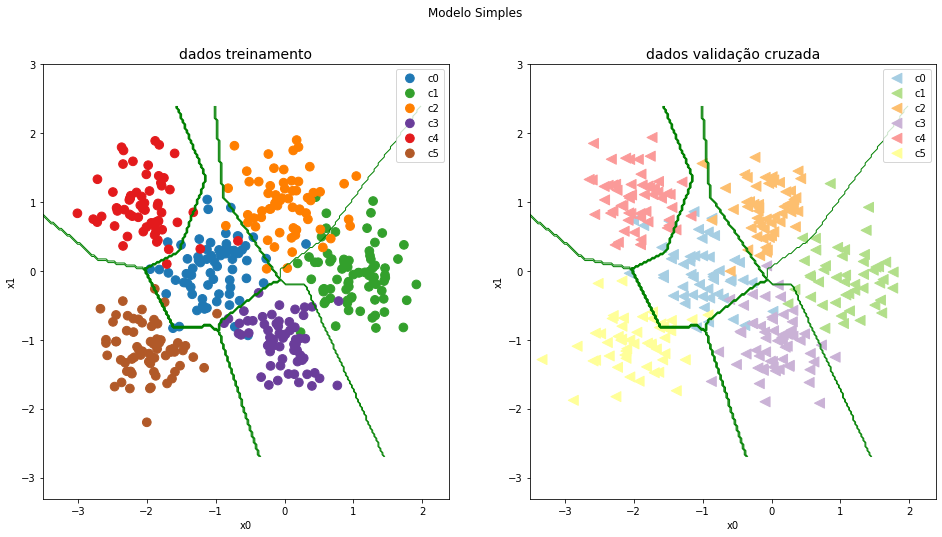

In [171]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao_simples = lambda Xl: np.argmax(tf.nn.softmax(modelo_simples.predict(Xl)).numpy(),axis=1)


plt_nn(modelo_previsao_simples,X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo Simples")

Esse modelo mais simples parece bem melhor. Vamos calcular os erros:

In [172]:
training_cerr_simples = calcula_erro_classificacao(y_train, modelo_previsao_simples(X_train))
cv_cerr_simples       = calcula_erro_classificacao(y_cv, modelo_previsao_simples(X_cv))
# adicionado devido à atividade
training_cacc_simples = calcula_acerto_classificacao(y_train, modelo_previsao_simples(X_train))
cv_cacc_simples       = calcula_acerto_classificacao(y_cv, modelo_previsao_simples(X_cv))
print(f"taxa de erro, treinamento, modelo simples: {100*training_cerr_simples:0.3f} %")
print(f"taxa de erro, cv,          modelo simples: {100*cv_cerr_simples:0.3f} %")
# adicionado devido à atividade
print(f"taxa de acerto, treinamento, modelo simples: {100*training_cacc_simples:0.3f} %")
print(f"taxa de acerto, cv,          modelo simples: {100*cv_cacc_simples:0.3f} %")

10/10 [==============================] - 0s 655us/step
taxa de erro, treinamento, modelo simples: 7.000 %
taxa de erro, cv,          modelo simples: 9.062 %
taxa de acerto, treinamento, modelo simples: 93.000 %
taxa de acerto, cv,          modelo simples: 90.938 %


Em comparação com o modelo mais complexo, note que o modelo mais simples tem uma taxa de erro de classificação um pouco maior para os dados de treinamento, porém sua taxa de erro para dados de validação cruzada é menor.

Ou seja, conseguimos assim resolver o problema de overfitting. Será que conseguimos obter um modelo ainda melhor?


## Regularização

Assim como no caso da regressão polinomial, é possível aplicar o conceito de regularização para moderar o impacto de um modelo mais complexo.

Abaixo, nós reconstruímos o modelo complexo, mas agora incluindo um termo de regularização.

In [173]:
tf.random.set_seed(1234)
modelo_regularizado = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # note o termo de regularização aqui
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)), # note o termo de regularização aqui
        tf.keras.layers.Dense(6, activation="linear")
    ], name= "Modelo_com_regularizacao"
)
modelo_regularizado.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)


In [174]:
modelo_regularizado.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 4.4036
Epoch 2/1000
13/13 [==============================] - 0s 954us/step - loss: 1.6395
Epoch 3/1000
13/13 [==============================] - 0s 968us/step - loss: 1.2885
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0544
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9744
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9575
Epoch 7/1000
13/13 [==============================] - 0s 831us/step - loss: 0.9196
Epoch 8/1000
13/13 [==============================] - 0s 875us/step - loss: 0.8899
Epoch 9/1000
13/13 [==============================] - 0s 946us/step - loss: 0.8203
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7724
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7618
Epoch 12/1000
13/13 [==============================] - 0s 892us/step - loss: 0.7569
Epoch 13/1000

In [175]:
modelo_regularizado.summary()

Model: "Modelo_com_regularizacao"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 120)               360       
                                                                 
 dense_198 (Dense)           (None, 40)                4840      
                                                                 
 dense_199 (Dense)           (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1082/1082 [==============================] - 1s 615us/step


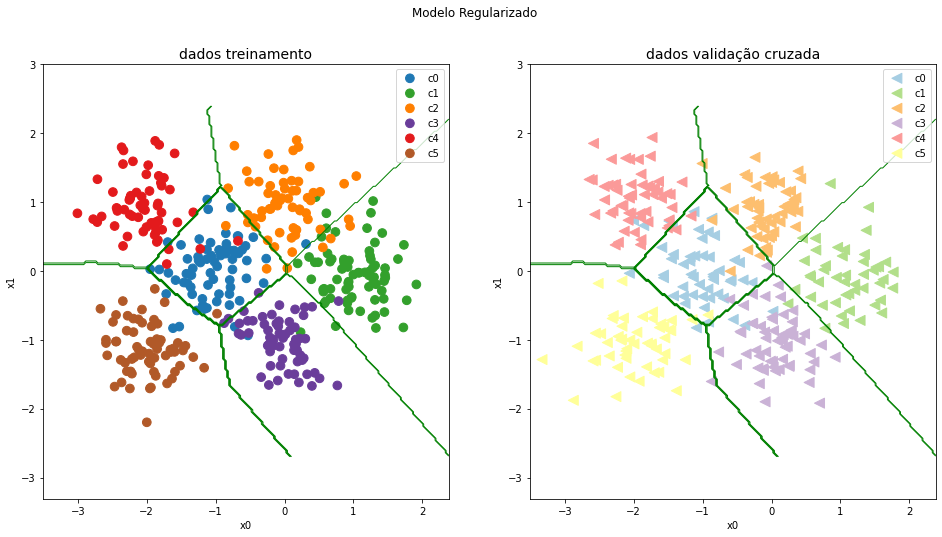

In [176]:
#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao_regularizado = lambda Xl: np.argmax(tf.nn.softmax(modelo_regularizado.predict(Xl)).numpy(),axis=1)

plt_nn(modelo_previsao_regularizado, X_train,y_train, classes, X_cv, y_cv, suptitle="Modelo Regularizado")

Estes resultados são muito parecidos com aqueles apresentados pelo modelo ideal. Abaixo nós calculamos os erros associados

In [177]:
training_cerr_regularizado = calcula_erro_classificacao(y_train, modelo_previsao_regularizado(X_train))
cv_cerr_regularizado       = calcula_erro_classificacao(y_cv, modelo_previsao_regularizado(X_cv))
# adicionado devido à atividade
training_cacc_regularizado = calcula_acerto_classificacao(y_train, modelo_previsao_regularizado(X_train))
cv_cacc_regularizado       = calcula_acerto_classificacao(y_cv, modelo_previsao_regularizado(X_cv))
print(f"taxa de erro, treinamento, modelo regularizado: {100*training_cerr_regularizado:0.3f} %")
print(f"taxa de erro, cv,          modelo regularizado: {100*cv_cerr_regularizado:0.3f} %")
# adicionado devido à atividade
print(f"taxa de acerto, treinamento, modelo regularizado: {100*training_cacc_regularizado:0.3f} %")
print(f"taxa de acerto, cv,          modelo regularizado: {100*cv_cacc_regularizado:0.3f} %")

10/10 [==============================] - 0s 780us/step
taxa de erro, treinamento, modelo regularizado: 7.500 %
taxa de erro, cv,          modelo regularizado: 7.187 %
taxa de acerto, treinamento, modelo regularizado: 92.500 %
taxa de acerto, cv,          modelo regularizado: 92.812 %


Compare os resultados obtidos para os três modelos.


## Em busca do $\lambda$ ótimo

Assim como nós fizemos para a regressão linear, nós podemos tentar diferentes valores para o parâmetro de regularização $\lambda$. Este código pode levar vários minutos para rodar.

In [178]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.45]
modelos=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_    = lambdas[i]
    modelos[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    modelos[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    modelos[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"lambda testado = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 1s 1ms/step - loss: 1.1099
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4222
Epoch 3/1000
13/13 [==============================] - 0s 997us/step - loss: 0.3070
Epoch 4/1000
13/13 [==============================] - 0s 951us/step - loss: 0.2842
Epoch 5/1000
13/13 [==============================] - 0s 972us/step - loss: 0.2848
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3029
Epoch 7/1000
13/13 [==============================] - 0s 931us/step - loss: 0.2416
Epoch 8/1000
13/13 [==============================] - 0s 948us/step - loss: 0.2259
Epoch 9/1000
13/13 [==============================] - 0s 989us/step - loss: 0.2284
Epoch 10/1000
13/13 [==============================] - 0s 900us/step - loss: 0.2032
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2202
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2091
Epoch 13/10

Abaixo nós plotamos os resultados obtidos

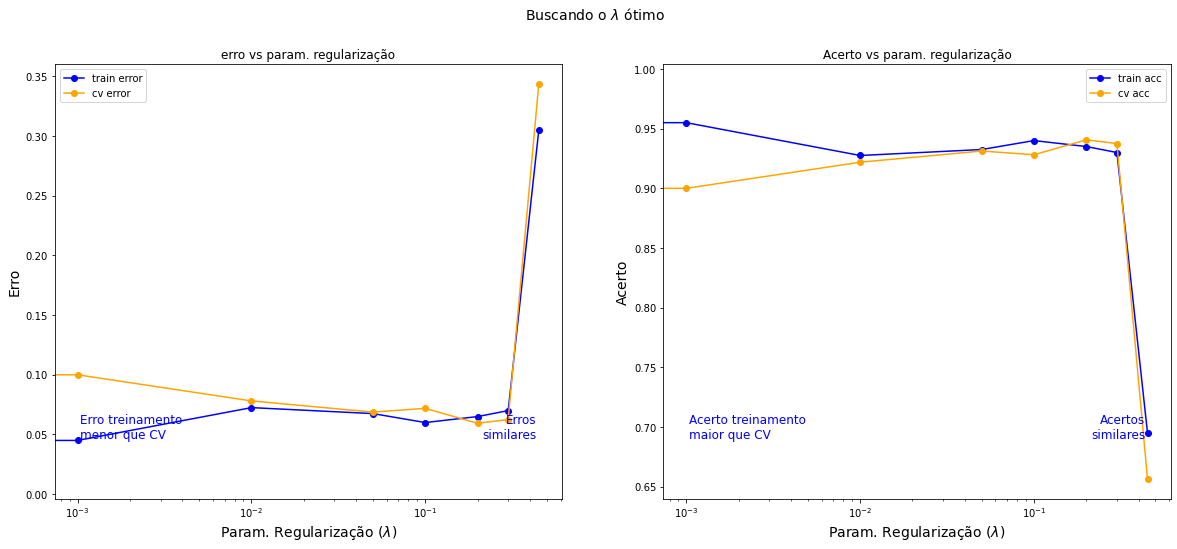

In [179]:
err_train = np.zeros(len(lambdas))
err_cv = np.zeros(len(lambdas))
# adicionado devido à atividade
acc_train = np.zeros(len(lambdas))
acc_cv = np.zeros(len(lambdas))
for i in range(len(modelos)):
    err_train[i] = calcula_erro_classificacao(y_train,np.argmax( modelos[i](X_train), axis=1))
    err_cv[i] = calcula_erro_classificacao(y_cv, np.argmax( modelos[i](X_cv), axis=1))    
    # adicionado devido à atividade
    acc_train[i] = calcula_acerto_classificacao(y_train,np.argmax( modelos[i](X_train), axis=1))
    acc_cv[i] = calcula_acerto_classificacao(y_cv, np.argmax( modelos[i](X_cv), axis=1))

fig, ax = plt.subplots(1,2,figsize=(20,8))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax[0].set_title("erro vs param. regularização",fontsize = 12)
ax[0].plot(lambdas, err_train, marker='o', label="train error", color = "blue")
ax[0].plot(lambdas, err_cv,    marker='o', label="cv error",    color = "orange")
ax[0].set_xscale('log')
ax[0].set_ylim(*ax[0].get_ylim())
ax[0].set_xlabel("Param. Regularização ($\lambda$)",fontsize = 14)
ax[0].set_ylabel("Erro",fontsize = 14)
ax[0].legend()
ax[0].text(0.05,0.14,"Erro treinamento\nmenor que CV",fontsize=12, ha='left',transform=ax[0].transAxes,color = "blue")
ax[0].text(0.95,0.14,"Erros\nsimilares",    fontsize=12, ha='right',transform=ax[0].transAxes,color = "blue")
# adicionado devido à atividade
ax[1].set_title("Acerto vs param. regularização",fontsize = 12)
ax[1].plot(lambdas, acc_train, marker='o', label="train acc", color = "blue")
ax[1].plot(lambdas, acc_cv,    marker='o', label="cv acc",    color = "orange")
ax[1].set_xscale('log')
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].set_xlabel("Param. Regularização ($\lambda$)",fontsize = 14)
ax[1].set_ylabel("Acerto",fontsize = 14)
ax[1].legend()
fig.suptitle("Buscando o $\lambda$ ótimo",fontsize = 14)
ax[1].text(0.05,0.14,"Acerto treinamento\nmaior que CV",fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
ax[1].text(0.95,0.14,"Acertos\nsimilares",    fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")

plt.show()

Qual valor para o parâmetro de regularização você escolheria?

**Resposta:** Visualmente falando, escolheria $\lambda = 0.05$ a $0.3$. Tanto na análise por erro quanto na análise por acertos é um valor onde o erro/acerto são similares e tem valores de mínimo/máximo de performance.